# Mecánica Celeste: teoría, algoritmos y problemas
# Por Jorge I. Zuluaga

En estos cuadernos hemos compilado la mayoría de los códigos que vienen con el libro [**Mecánica Celeste: teoría, algoritmos y problemas**](https://www.buscalibre.com.co/libro-mecanica-celeste-teoria-algoritmos-y-problemas/9789585011953/p/62242977?afiliado=74c874bfb5a8145d7c1b). En cada cuaderno encontrará códigos de secciones o capítulos enteros. Para explicaciones detalladas de lo que hacen los códigos refiérase a la sección o capítulo respectivo. Para mayor comodidad puede leer o ejecutar este cuaderno usando `Google Colab`.

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/pymcel/blob/main/ejemplos/cuadernos-libro/mcel_zuluaga-20-lagrangiano_generalidades.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Algorítmos plantilla

### Instalación e importación

Si está usando este cuaderno en `Colab` debería instalar `pymcel` antes de comenzar: 

In [16]:
!pip install -Uq pymcel

In [1]:
# Este código se usa solamente para desarrollar estos cuadernos pero es inocuo en otros contextos
%load_ext autoreload 
%autoreload 2

### Un ejemplo: el péndulo elástico

Las ecuaciones de movimiento del péndulo elástico son:

In [1]:
def edm_penduloelastico(Y,t,L,k,m):    
    #Constantes físicas
    g=9.81

    # Lee variables
    q1,q2,q1p,q2p=Y
    
    # Velocidades
    dq1dt=q1p
    dq2dt=q2p
    
    # Aceleraciones
    from numpy import sin,cos
    dq1pdt=(-g*sin(q1)-2*q1p*q2p)/(L+q2)
    dq2pdt=(L+q2)*q1p**2+g*cos(q1)-(k/m)*q2
    
    return [dq1dt,dq2dt,dq1pdt,dq2pdt]

Para resolver estas ecuaciònes definimos las condiciones iniciales y escogemos el tiempo en el que se desea obtener la solución:

In [2]:
#Propiedades del sistema
L=1.0
k=20.0
m=1.0

#Condiciones iniciales
from numpy import pi
y=[pi/3,0.1,0.0,0.0]

#Tiempos de integración
from numpy import linspace
Nt=200
ts=linspace(0,10,Nt)

Resolvemos:

In [3]:
from scipy.integrate import odeint
solucion=odeint(edm_penduloelastico,y,ts,args=(L,k,m))
q1s=solucion[:,0]
q2s=solucion[:,1]

Podemos visualizar el valor de las variables generalizadas como función del tiempo con el siguiente algortimo:

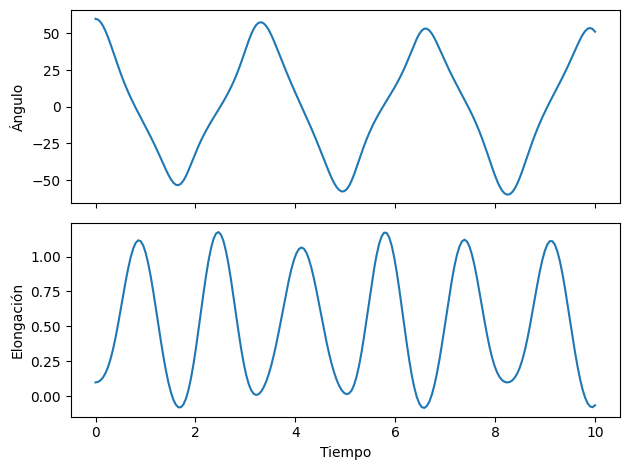

In [5]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(ts,q1s*180/pi)
axs[0].set_ylabel("Ángulo")
axs[1].plot(ts,q2s)
axs[1].set_ylabel("Elongación")
axs[1].set_xlabel("Tiempo")
fig.tight_layout()

Sin embargo, la mejor manera de comprobar que la dinámica se ajusta a nuestras expectativas es mostrar el movimiento del sistema en el espacio de coordenadas. Para ello es necesario que hagamos la transformación de variables generalizadas a coordenadas:

In [6]:
from numpy import sin,cos,zeros_like
xs=(L+q2s)*sin(q1s)
ys=-(L+q2s)*cos(q1s)
zs=zeros_like(xs)

Una gráfica de la trayectoria de la partícula en el espacio físico se obtiene finalmente con este código:

Paquete pymcel cargado. Versión: 0.6.0


((-2.1436830301063283, 2.1436830301063283),
 (-2.24215128135042, 0.9526279441628827))

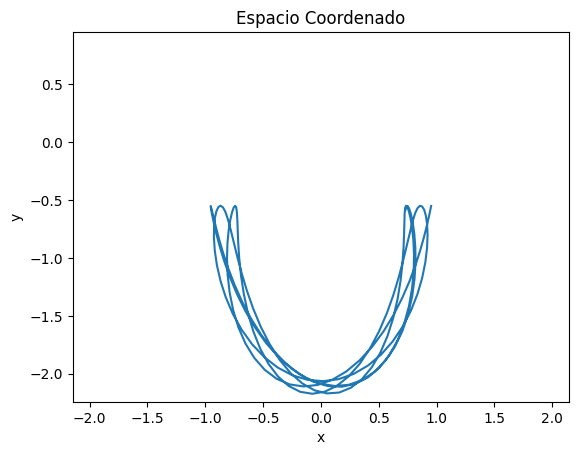

In [7]:
fig=plt.figure()
ax=fig.gca()

ax.plot(xs,ys)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Espacio Coordenado")
from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,(xs,ys),xcm=0)

Una animación del movimiento del péndulo puede crearse con este código:

In [12]:
#Prepara la figura
fig=plt.figure(figsize=(6,6))
ax=fig.gca()

#Posición del cuerpo
particula,=ax.plot([],[],color='k',marker='o',markersize=15)
#Trayectoria
trayectoria,=ax.plot([],[],'r-')
#Cuerda
cuerda,=ax.plot([],[],'b-')
#Texto con el tiempo
tiempo=ax.text(0.05,0.9,'',transform=ax.transAxes)
#Rangos de la figura
fija_ejes_proporcionales(ax,(xs,ys),xcm=0);
#xlim=ax.set_xlim((-0.9*L,0.9*L))
#ylim=ax.set_ylim((-1.8*L,0.0))

#Rutina de animación
def animacion(it):
    x=xs[it]
    y=ys[it]
    particula.set_data([x],[y])
    trayectoria.set_data(xs[:it],ys[:it])
    cuerda.set_data([0,x],[0,y])
    tiempo.set_text("t = %.2f s"%ts[it])
    return particula,trayectoria,cuerda

#animacion(5)
from matplotlib import animation
anim=animation.FuncAnimation(fig,animacion,frames=Nt,interval=30,blit=True,repeat=False)
plt.close('all')

from IPython.display import HTML
HTML(anim.to_jshtml())

### El principio de Hamilton

#### Un ejemplo: el péndulo simple

Implementemos el cálculo del lagrangiano como una rutina:

In [13]:
#Valor global de la aceleración de la gravedad
g=9.81

#Ruina del lagrangiano del péndulo simple
def lagrangiano_pendulo_simple(q,dqdt,t,teta0=0,m=1,L=1):
    from numpy import cos
    L_PS=0.5*m*L**2*dqdt**2-m*g*L*cos(q)
    return L_PS

La rutina de la trayectoria del péndulo simple será:

In [14]:
def q0_pendulo_simple(t,teta0=0,m=1,L=1):
    from numpy import sqrt,cos
    w=sqrt(g/L)
    q=teta0*cos(w*t)
    return q

La función de plantilla será:

In [15]:
def eta_pendulo_simple(t,teta0=0,m=1,L=1):
    from numpy import sqrt,sin
    w=sqrt(g/L)
    eta=sin(w*t/2)
    return eta

El cálculo de la acción se haría con la rutina:

In [16]:
def accion_hamilton(lagrangiano,q0,eta,epsilon,t1,t2,**opciones_de_L):
    
    #Definimos las función con su variación
    q=lambda t:q0(t,**opciones_de_L)+epsilon*eta(t,**opciones_de_L)
    
    #La derivada de q la calculamos con derivative
    from scipy.misc import derivative
    dqdt=lambda t:derivative(q,t,0.01)
        
    #Lagrangiano del péndulo simple
    Lsistema=lambda t:lagrangiano(q(t),dqdt(t),t,**opciones_de_L)

    #El funcional es la integral definida del integrando
    from scipy.integrate import quad
    integral=quad(Lsistema,t1,t2)
    S=integral[0]
    
    return S

El valor de la acción para la trayectoria que ese la solución será:

In [18]:
#Propiedades del sistema
longitud=1
masa=1

#Condición inicial
from numpy import pi,sqrt
teta0=pi/3

#Parametro omega
w=sqrt(g/longitud)

#Intervalo de interés
t1=0.0
t2=2*pi/w

#Valor de la accion
epsilon=0.0
S=accion_hamilton(lagrangiano_pendulo_simple,
                  q0_pendulo_simple,
                  eta_pendulo_simple,
                  epsilon,
                  t1,t2,
                  teta0=teta0,L=longitud,m=masa)

print(f"S_PS (epsilon = {epsilon}) = {S}")

S_PS (epsilon = 0.0) = -9.249488346756532


/tmp/ipykernel_34941/3184123138.py:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dqdt=lambda t:derivative(q,t,0.01)


Un gráfico de la acción como función de $\epsilon$ será:

/tmp/ipykernel_34941/3184123138.py:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dqdt=lambda t:derivative(q,t,0.01)


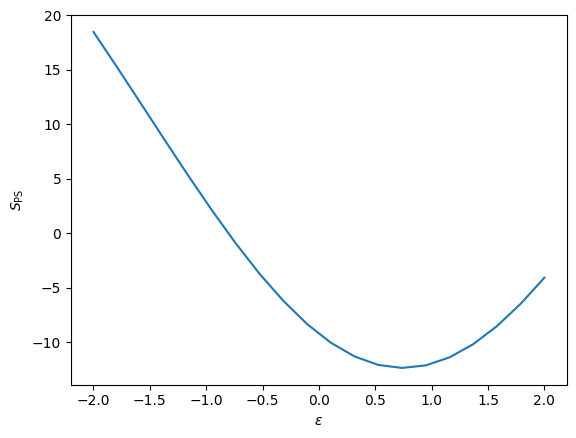

In [19]:
#Simplificamos el cálculo de la acción definiendo una función lambda
S_eps=lambda eps:accion_hamilton(lagrangiano_pendulo_simple,
                                 q0_pendulo_simple,
                                 eta_pendulo_simple,
                                 eps,
                                 t1,t2,
                                 teta0=teta0,L=longitud,m=masa)

#Valores posibles de epsilon
from numpy import linspace
eps=linspace(-2,2,20)

#Valores de la acción
S=[S_eps(epsilon) for epsilon in eps]

#Gráfico
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()
ax.plot(eps,S);
#Decoración
ax.set_xlabel("$\epsilon$");
ax.set_ylabel("$S_\mathrm{PS}$");

Minimizamos la acción para encontrar la trayectoria clásica:

In [21]:
from scipy.optimize import minimize
solucion=minimize(S_eps,0.0)

print(f"Resultado de la minimización:\n{solucion}")

Resultado de la minimización:
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -12.371224415368705
        x: [ 7.457e-01]
      nit: 4
      jac: [-1.192e-07]
 hess_inv: [[ 8.692e-02]]
     nfev: 10
     njev: 5


/tmp/ipykernel_34941/3184123138.py:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dqdt=lambda t:derivative(q,t,0.01)


Un gráfico de la trayectoria de mínima acción del péndulo y algunas trayectorias "vecinas" con un valor de la acción mayor se puede elaborar con esta algoritmo:

/tmp/ipykernel_34941/3184123138.py:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dqdt=lambda t:derivative(q,t,0.01)


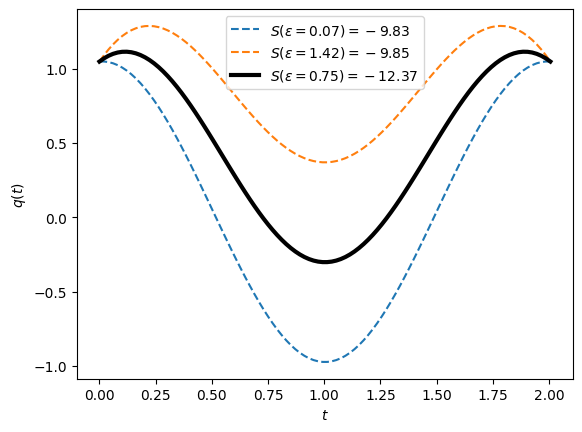

In [22]:
fig=plt.figure()
ax=fig.gca()

#Tiempos
from numpy import linspace
ts=linspace(t1,t2,100)

eps_min=solucion.x[0]
eps_men=0.1*eps_min
eps_may=1.9*eps_min
for epsilon in [eps_men,eps_may]:
    #Calcula el valor de la acción
    S=S_eps(epsilon)
    #Calculo de la función
    qs=q0_pendulo_simple(ts,teta0=teta0,m=masa,L=longitud)+\
       epsilon*eta_pendulo_simple(ts,teta0=teta0,m=masa,L=longitud)
    ax.plot(ts,qs,ls='--',
            label=f"$S(\epsilon={epsilon:.2f}) = {S:.2f}$")

epsilon=eps_min
S=S_eps(epsilon)
qs=q0_pendulo_simple(ts,teta0=teta0,m=masa,L=longitud)+\
   epsilon*eta_pendulo_simple(ts,teta0=teta0,m=masa,L=longitud)
ax.plot(ts,qs,'k-',lw=3,label=f"$S(\epsilon={epsilon:.2f}) = {S:.2f}$")

#Decoración
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$q(t)$");

<hr/>

Para explorar más cuadernos del libro vaya al [repositorio de en GitHub](https://github.com/seap-udea/pymcel/tree/main/ejemplos/cuadernos-libro)